In [10]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix  # new import for confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix  # new import for confusion matrix
import matplotlib.pyplot as plt

In [11]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and labels for classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).

    Attributes:
        texts (pd.Series): Processed texts with reset indices.
        labels: Processed labels with reset indices (if pandas Series).
        tokenizer: Provided tokenizer instance.
        max_length (int): Maximum length for padding/truncation.
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        label = self.labels[idx]
        if not isinstance(label, (list, np.ndarray)):
            label = [label]
        # Convert one-hot encoded label to class index
        label = int(np.argmax(label))
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for single-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top.
    
    Args:
        num_labels (int): Number of classes in the classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for CrossEntropyLoss
        return self.classifier(pooled_output)

In [13]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For single-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

In [14]:

def train_epoch(model, loader, criterion, optimizer, device, early_stopping=None):
    """
    Train the model for one epoch, computing loss and accuracy, and apply early stopping if needed.

    Args:
        model (nn.Module): The classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_elements = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).squeeze()  # Assumes labels are scalar indices
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_elements += labels.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_elements
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, accuracy, True
    return avg_loss, accuracy, False
    

In [15]:

def validate(model, loader, criterion, device):
    """
    Evaluate the model on provided validation data.

    Args:
        model (nn.Module): The classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function.
        device: Device to perform evaluation.

    Returns:
        tuple: Average loss, accuracy, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return total_loss / len(loader), accuracy, precision, recall, f1


# Test 1 : Use all data

In [16]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json'
    data = pd.read_json(filepath)
    data = data[['all_text','labels']]
    data = data[data.all_text != "nan"]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))
    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  454
area/apiserver             177
area/kubelet               172
area/kubectl               154
area/e2e-test-framework     97
area/kubeadm                92
area/code-generation        80
area/cloudprovider          72
area/dependency             68
area/release-eng            30
area/conformance            26
area/provider/gcp           19
area/kube-proxy             17
area/provider/azure         14
area/ipvs                   11
area/network-policy          7
area/stable-metrics          5
area/admission-control       5
area/custom-resources        5
area/kubelet-api             5
area/ipv6                    4
area/logging                 3
area/provider/openstack      3
area/hw-accelerators         2
area/client-libraries        2
area/code-organization       2
area/etcd                    1
area/test-infra              1
area/security                1
area/batch                   1
area/worklo

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Training: 100%|██████████| 134/134 [00:52<00:00,  2.58it/s]


Epoch 1:
Train Loss: 2.6089, Train Accuracy: 0.2799
Val Loss: 2.3305, Val Accuracy: 0.3087
Val Precision: 0.0129, Val Recall: 0.0417, Val F1: 0.0197


Training: 100%|██████████| 134/134 [00:57<00:00,  2.31it/s]


Epoch 2:
Train Loss: 2.3389, Train Accuracy: 0.3078
Val Loss: 2.1173, Val Accuracy: 0.3565
Val Precision: 0.0495, Val Recall: 0.0703, Val F1: 0.0560


Training: 100%|██████████| 134/134 [01:00<00:00,  2.23it/s]


Epoch 3:
Train Loss: 2.0065, Train Accuracy: 0.4328
Val Loss: 1.8810, Val Accuracy: 0.4391
Val Precision: 0.1148, Val Recall: 0.1210, Val F1: 0.1096


Training: 100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch 4:
Train Loss: 1.7552, Train Accuracy: 0.4869
Val Loss: 1.8280, Val Accuracy: 0.4609
Val Precision: 0.1236, Val Recall: 0.1555, Val F1: 0.1304


Training: 100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch 5:
Train Loss: 1.6407, Train Accuracy: 0.5000
Val Loss: 1.7252, Val Accuracy: 0.4609
Val Precision: 0.1167, Val Recall: 0.1478, Val F1: 0.1282


Training: 100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch 6:
Train Loss: 1.5628, Train Accuracy: 0.5196
Val Loss: 1.7388, Val Accuracy: 0.4130
Val Precision: 0.1270, Val Recall: 0.1575, Val F1: 0.1376


Training: 100%|██████████| 134/134 [01:00<00:00,  2.23it/s]


Epoch 7:
Train Loss: 1.4923, Train Accuracy: 0.5196
Val Loss: 1.6871, Val Accuracy: 0.4478
Val Precision: 0.1138, Val Recall: 0.1417, Val F1: 0.1253


Training: 100%|██████████| 134/134 [01:00<00:00,  2.23it/s]


Epoch 8:
Train Loss: 1.4347, Train Accuracy: 0.5252
Val Loss: 1.7644, Val Accuracy: 0.4304
Val Precision: 0.1203, Val Recall: 0.1320, Val F1: 0.1193


Training: 100%|██████████| 134/134 [01:00<00:00,  2.23it/s]


Epoch 9:
Train Loss: 1.3939, Train Accuracy: 0.5373
Val Loss: 1.7366, Val Accuracy: 0.4130
Val Precision: 0.1355, Val Recall: 0.1703, Val F1: 0.1474


Training: 100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch 10:
Train Loss: 1.3526, Train Accuracy: 0.5373
Val Loss: 1.7307, Val Accuracy: 0.4261
Val Precision: 0.1245, Val Recall: 0.1428, Val F1: 0.1291
Test Loss: 1.9856
Test Accuracy: 0.3843
Test Precision: 0.1726
Test Recall: 0.2141
Test F1 Score: 0.1891

Label Frequencies on Test Set:
area/apiserver: 23
area/cloudprovider: 11
area/code-generation: 14
area/conformance: 3
area/custom-resources: 2
area/dependency: 8
area/e2e-test-framework: 19
area/ipvs: 4
area/kube-proxy: 6
area/kubeadm: 11
area/kubectl: 23
area/kubelet: 29
area/kubelet-api: 1
area/logging: 1
area/network-policy: 1
area/provider/gcp: 2
area/release-eng: 6
area/test: 65


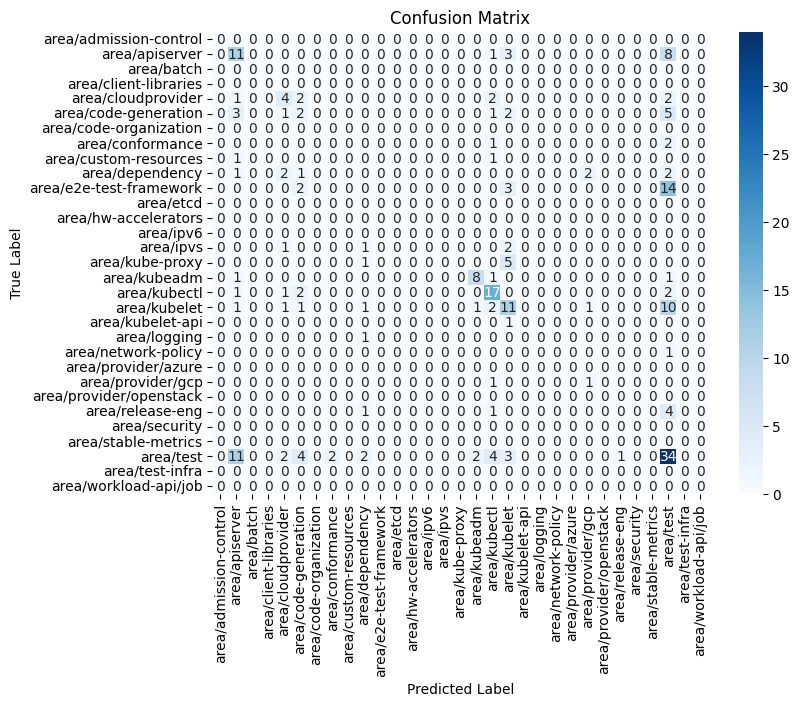

In [17]:
if __name__ == '__main__':
    main()

# Test 2 : Use all data where there are more than 10 samples per label

In [18]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json'
    data = pd.read_json(filepath)
    data = data[['all_text','labels']]
    data = data[data.all_text != "nan"]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  454
area/apiserver             177
area/kubelet               172
area/kubectl               154
area/e2e-test-framework     97
area/kubeadm                92
area/code-generation        80
area/cloudprovider          72
area/dependency             68
area/release-eng            30
area/conformance            26
area/provider/gcp           19
area/kube-proxy             17
area/provider/azure         14
area/ipvs                   11
area/network-policy          7
area/admission-control       5
area/stable-metrics          5
area/kubelet-api             4
area/logging                 3
area/custom-resources        2
area/etcd                    1
area/security                1
area/test-infra              1
area/code-organization       1
area/batch                   1
area/workload-api/job        1
Name: count, dtype: int64


Training: 100%|██████████| 133/133 [01:00<00:00,  2.21it/s]


Epoch 1:
Train Loss: 2.5206, Train Accuracy: 0.3009
Val Loss: 2.3484, Val Accuracy: 0.2939
Val Precision: 0.0147, Val Recall: 0.0500, Val F1: 0.0227


Training: 100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


Epoch 2:
Train Loss: 2.2370, Train Accuracy: 0.3330
Val Loss: 2.0282, Val Accuracy: 0.3947
Val Precision: 0.0891, Val Recall: 0.1233, Val F1: 0.0976


Training: 100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


Epoch 3:
Train Loss: 1.8987, Train Accuracy: 0.4557
Val Loss: 1.8413, Val Accuracy: 0.4254
Val Precision: 0.1579, Val Recall: 0.1778, Val F1: 0.1491


Training: 100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


Epoch 4:
Train Loss: 1.6962, Train Accuracy: 0.4830
Val Loss: 1.7094, Val Accuracy: 0.4956
Val Precision: 0.1540, Val Recall: 0.2249, Val F1: 0.1823


Training: 100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


Epoch 5:
Train Loss: 1.5938, Train Accuracy: 0.5009
Val Loss: 1.7084, Val Accuracy: 0.4737
Val Precision: 0.1418, Val Recall: 0.2161, Val F1: 0.1686


Training: 100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


Epoch 6:
Train Loss: 1.4983, Train Accuracy: 0.5057
Val Loss: 1.6805, Val Accuracy: 0.4781
Val Precision: 0.1479, Val Recall: 0.2038, Val F1: 0.1680


Training: 100%|██████████| 133/133 [00:59<00:00,  2.23it/s]


Epoch 7:
Train Loss: 1.4630, Train Accuracy: 0.5094
Val Loss: 1.6816, Val Accuracy: 0.4781
Val Precision: 0.2079, Val Recall: 0.2269, Val F1: 0.2014


Training: 100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


Epoch 8:
Train Loss: 1.3933, Train Accuracy: 0.5311
Val Loss: 1.7001, Val Accuracy: 0.4781
Val Precision: 0.2040, Val Recall: 0.2375, Val F1: 0.1978


Training: 100%|██████████| 133/133 [00:59<00:00,  2.24it/s]


Epoch 9:
Train Loss: 1.3491, Train Accuracy: 0.5330
Val Loss: 1.6995, Val Accuracy: 0.4693
Val Precision: 0.2416, Val Recall: 0.2389, Val F1: 0.2164


Training: 100%|██████████| 133/133 [00:59<00:00,  2.22it/s]


Epoch 10:
Train Loss: 1.3077, Train Accuracy: 0.5349
Val Loss: 1.7372, Val Accuracy: 0.4430
Val Precision: 0.1795, Val Recall: 0.1966, Val F1: 0.1770
Test Loss: 2.0061
Test Accuracy: 0.4009
Test Precision: 0.1351
Test Recall: 0.1182
Test F1 Score: 0.1159

Label Frequencies on Test Set:
area/admission-control: 1
area/apiserver: 29
area/batch: 1
area/cloudprovider: 15
area/code-generation: 9
area/conformance: 3
area/dependency: 8
area/e2e-test-framework: 20
area/etcd: 1
area/ipvs: 3
area/kube-proxy: 6
area/kubeadm: 15
area/kubectl: 16
area/kubelet: 29
area/kubelet-api: 1
area/logging: 1
area/network-policy: 1
area/provider/azure: 1
area/release-eng: 3
area/stable-metrics: 1
area/test: 62
area/workload-api/job: 1


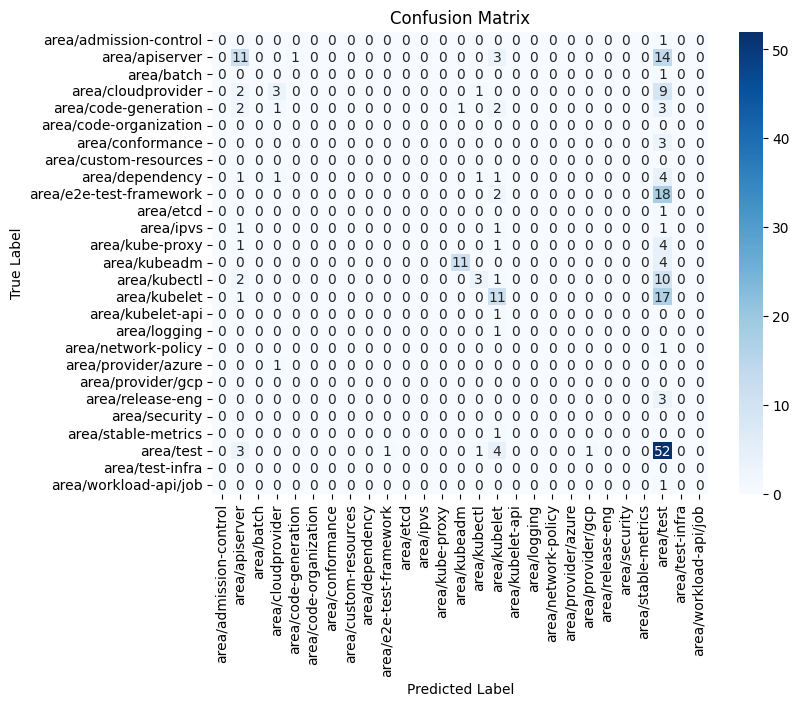

In [19]:
if __name__ == '__main__':
    main()

# Test 3 : Only retain data that have 1 labels

In [20]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json'
    data = pd.read_json(filepath)
    data = data[['all_text','labels']]
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 1]
    data = data.explode('labels').reset_index(drop=True)
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Training: 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


Epoch 1:
Train Loss: 2.4537, Train Accuracy: 0.2978
Val Loss: 2.3854, Val Accuracy: 0.2763
Val Precision: 0.0197, Val Recall: 0.0714, Val F1: 0.0309


Training: 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


Epoch 2:
Train Loss: 2.0665, Train Accuracy: 0.3315
Val Loss: 2.3426, Val Accuracy: 0.3289
Val Precision: 0.1198, Val Recall: 0.1079, Val F1: 0.0911


Training: 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


Epoch 3:
Train Loss: 1.8171, Train Accuracy: 0.4298
Val Loss: 2.0036, Val Accuracy: 0.5263
Val Precision: 0.1428, Val Recall: 0.2207, Val F1: 0.1731


Training: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


Epoch 4:
Train Loss: 1.3845, Train Accuracy: 0.6826
Val Loss: 1.7262, Val Accuracy: 0.6053
Val Precision: 0.2246, Val Recall: 0.2820, Val F1: 0.2470


Training: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


Epoch 5:
Train Loss: 1.0862, Train Accuracy: 0.7556
Val Loss: 1.4787, Val Accuracy: 0.6711
Val Precision: 0.2551, Val Recall: 0.3398, Val F1: 0.2830


Training: 100%|██████████| 45/45 [00:19<00:00,  2.28it/s]


Epoch 6:
Train Loss: 0.8099, Train Accuracy: 0.8202
Val Loss: 1.3267, Val Accuracy: 0.6974
Val Precision: 0.3255, Val Recall: 0.3684, Val F1: 0.3266


Training: 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


Epoch 7:
Train Loss: 0.6708, Train Accuracy: 0.8624
Val Loss: 1.2504, Val Accuracy: 0.7368
Val Precision: 0.3397, Val Recall: 0.4003, Val F1: 0.3600


Training: 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


Epoch 8:
Train Loss: 0.5767, Train Accuracy: 0.8708
Val Loss: 1.1000, Val Accuracy: 0.7632
Val Precision: 0.3338, Val Recall: 0.4180, Val F1: 0.3664


Training: 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


Epoch 9:
Train Loss: 0.5116, Train Accuracy: 0.8961
Val Loss: 1.0268, Val Accuracy: 0.7632
Val Precision: 0.3226, Val Recall: 0.4180, Val F1: 0.3581


Training: 100%|██████████| 45/45 [00:19<00:00,  2.29it/s]


Epoch 10:
Train Loss: 0.4335, Train Accuracy: 0.9045
Val Loss: 1.0243, Val Accuracy: 0.7632
Val Precision: 0.3228, Val Recall: 0.4180, Val F1: 0.3584
Test Loss: 1.0582
Test Accuracy: 0.7632
Test Precision: 0.3981
Test Recall: 0.4201
Test F1 Score: 0.4033

Label Frequencies on Test Set:
area/apiserver: 9
area/cloudprovider: 2
area/dependency: 1
area/e2e-test-framework: 1
area/hw-accelerators: 1
area/ipv6: 1
area/kubeadm: 10
area/kubectl: 16
area/kubelet: 8
area/provider/gcp: 2
area/test: 25


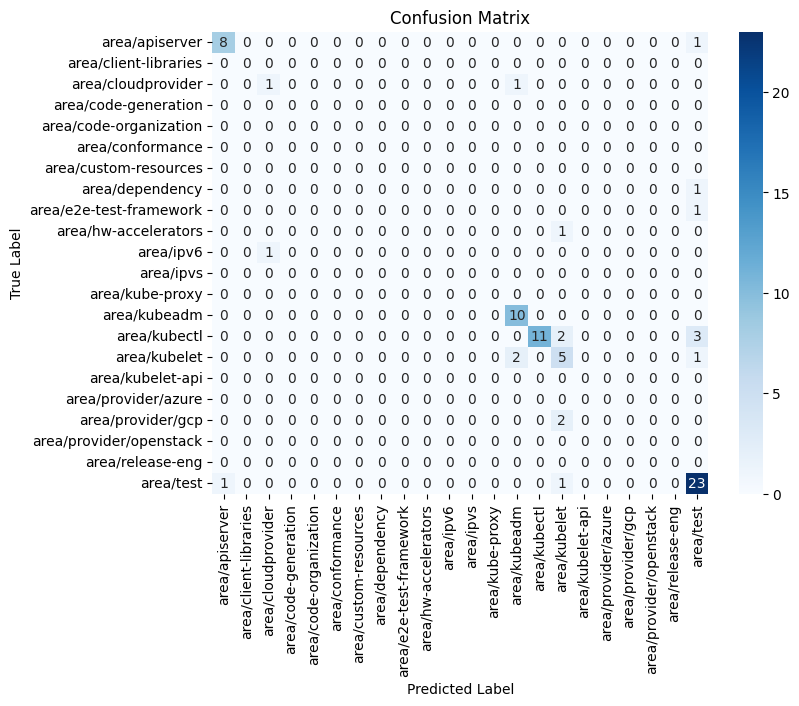

In [21]:
if __name__ == '__main__':
    main()

# Test 4 : Only retain data that have 1 labels and filter only use labels that have >10 rows

In [22]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json'
    data = pd.read_json(filepath)
    data = data[['all_text','labels']]
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 1]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)
    # data.to_json('final_data.json', orient='records')

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())

    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test             161
area/kubectl           75
area/kubeadm           67
area/apiserver         65
area/kubelet           64
area/cloudprovider     22
Name: count, dtype: int64


Training: 100%|██████████| 40/40 [00:17<00:00,  2.24it/s]


Epoch 1:
Train Loss: 1.6943, Train Accuracy: 0.3333
Val Loss: 1.6231, Val Accuracy: 0.3971
Val Precision: 0.0662, Val Recall: 0.1667, Val F1: 0.0947


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Epoch 2:
Train Loss: 1.6310, Train Accuracy: 0.3491
Val Loss: 1.5380, Val Accuracy: 0.3971
Val Precision: 0.0662, Val Recall: 0.1667, Val F1: 0.0947


Training: 100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


Epoch 3:
Train Loss: 1.3645, Train Accuracy: 0.4874
Val Loss: 0.8211, Val Accuracy: 0.8382
Val Precision: 0.7157, Val Recall: 0.7125, Val F1: 0.7061


Training: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


Epoch 4:
Train Loss: 0.6926, Train Accuracy: 0.8019
Val Loss: 0.3588, Val Accuracy: 0.8824
Val Precision: 0.7452, Val Recall: 0.7653, Val F1: 0.7486


Training: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


Epoch 5:
Train Loss: 0.3726, Train Accuracy: 0.8931
Val Loss: 0.2047, Val Accuracy: 0.9559
Val Precision: 0.9734, Val Recall: 0.9472, Val F1: 0.9588


Training: 100%|██████████| 40/40 [00:17<00:00,  2.28it/s]


Epoch 6:
Train Loss: 0.2564, Train Accuracy: 0.9340
Val Loss: 0.1963, Val Accuracy: 0.9265
Val Precision: 0.9363, Val Recall: 0.8638, Val F1: 0.8824


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Epoch 7:
Train Loss: 0.1488, Train Accuracy: 0.9748
Val Loss: 0.0896, Val Accuracy: 0.9706
Val Precision: 0.9885, Val Recall: 0.9710, Val F1: 0.9789


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Epoch 8:
Train Loss: 0.1236, Train Accuracy: 0.9717
Val Loss: 0.0968, Val Accuracy: 0.9706
Val Precision: 0.9885, Val Recall: 0.9710, Val F1: 0.9789


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Epoch 9:
Train Loss: 0.0831, Train Accuracy: 0.9811
Val Loss: 0.0790, Val Accuracy: 0.9706
Val Precision: 0.9885, Val Recall: 0.9710, Val F1: 0.9789


Training: 100%|██████████| 40/40 [00:17<00:00,  2.27it/s]


Epoch 10:
Train Loss: 0.0737, Train Accuracy: 0.9874
Val Loss: 0.1142, Val Accuracy: 0.9706
Val Precision: 0.9885, Val Recall: 0.9710, Val F1: 0.9789
Test Loss: 0.2774
Test Accuracy: 0.8971
Test Precision: 0.9355
Test Recall: 0.9043
Test F1 Score: 0.9171

Label Frequencies on Test Set:
area/apiserver: 10
area/cloudprovider: 2
area/kubeadm: 10
area/kubectl: 10
area/kubelet: 13
area/test: 23


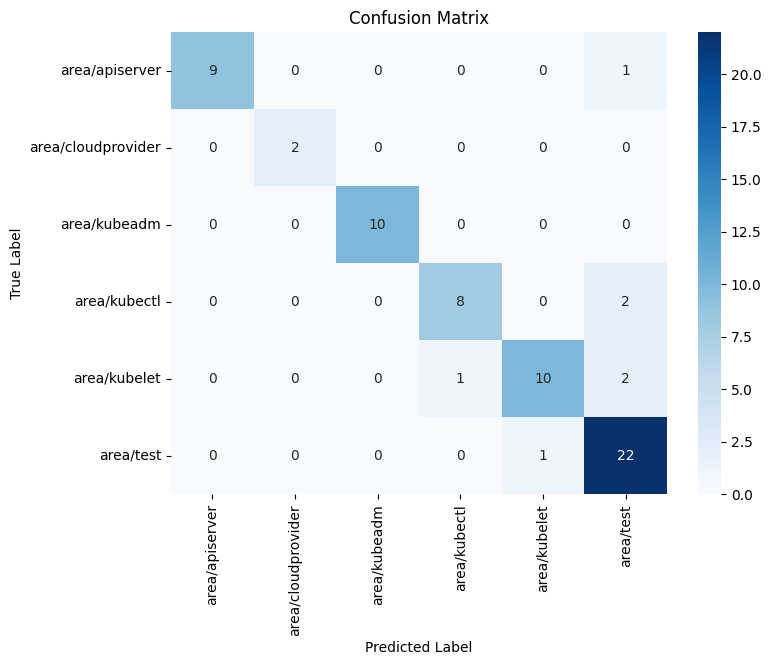

In [23]:
if __name__ == '__main__':
    main()

# Test 4 : Only retain data that have max 2 labels and filter only use labels that have >10 rows

In [24]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json'
    data = pd.read_json(filepath)
    data = data[['all_text','labels']]
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 2]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  346
area/apiserver             112
area/kubelet               109
area/kubectl               101
area/kubeadm                74
area/e2e-test-framework     63
area/cloudprovider          38
area/code-generation        22
area/dependency             19
area/conformance            15
area/provider/azure         12
area/provider/gcp           11
area/release-eng             6
area/kubelet-api             3
area/kube-proxy              2
area/ipvs                    2
area/admission-control       2
area/custom-resources        2
area/etcd                    1
area/security                1
area/test-infra              1
area/code-organization       1
area/stable-metrics          1
Name: count, dtype: int64


Training: 100%|██████████| 83/83 [00:37<00:00,  2.24it/s]


Epoch 1:
Train Loss: 2.3304, Train Accuracy: 0.3540
Val Loss: 2.2237, Val Accuracy: 0.3310
Val Precision: 0.0207, Val Recall: 0.0625, Val F1: 0.0311


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 2:
Train Loss: 2.0008, Train Accuracy: 0.3767
Val Loss: 1.9057, Val Accuracy: 0.4789
Val Precision: 0.2087, Val Recall: 0.2022, Val F1: 0.1658


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 3:
Train Loss: 1.5508, Train Accuracy: 0.5658
Val Loss: 1.4647, Val Accuracy: 0.5775
Val Precision: 0.1836, Val Recall: 0.2565, Val F1: 0.2113


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 4:
Train Loss: 1.2444, Train Accuracy: 0.6490
Val Loss: 1.3127, Val Accuracy: 0.6127
Val Precision: 0.2336, Val Recall: 0.2890, Val F1: 0.2534


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 5:
Train Loss: 1.1055, Train Accuracy: 0.6596
Val Loss: 1.2284, Val Accuracy: 0.6408
Val Precision: 0.2418, Val Recall: 0.3251, Val F1: 0.2752


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 6:
Train Loss: 1.0153, Train Accuracy: 0.6823
Val Loss: 1.1855, Val Accuracy: 0.6268
Val Precision: 0.2766, Val Recall: 0.3482, Val F1: 0.3024


Training: 100%|██████████| 83/83 [00:36<00:00,  2.25it/s]


Epoch 7:
Train Loss: 0.9235, Train Accuracy: 0.6914
Val Loss: 1.2079, Val Accuracy: 0.6197
Val Precision: 0.2472, Val Recall: 0.3112, Val F1: 0.2695


Training: 100%|██████████| 83/83 [00:36<00:00,  2.26it/s]


Epoch 8:
Train Loss: 0.8708, Train Accuracy: 0.6989
Val Loss: 1.2195, Val Accuracy: 0.6127
Val Precision: 0.2567, Val Recall: 0.3122, Val F1: 0.2744


Training: 100%|██████████| 83/83 [00:36<00:00,  2.26it/s]


Epoch 9:
Train Loss: 0.8184, Train Accuracy: 0.7050
Val Loss: 1.1818, Val Accuracy: 0.6056
Val Precision: 0.2555, Val Recall: 0.2892, Val F1: 0.2675


Training: 100%|██████████| 83/83 [00:36<00:00,  2.26it/s]


Epoch 10:
Train Loss: 0.8015, Train Accuracy: 0.7110
Val Loss: 1.1495, Val Accuracy: 0.6479
Val Precision: 0.2850, Val Recall: 0.3538, Val F1: 0.3141
Test Loss: 1.2598
Test Accuracy: 0.6099
Test Precision: 0.2652
Test Recall: 0.3564
Test F1 Score: 0.2966

Label Frequencies on Test Set:
area/apiserver: 13
area/cloudprovider: 4
area/code-generation: 5
area/conformance: 4
area/dependency: 3
area/e2e-test-framework: 8
area/ipvs: 1
area/kube-proxy: 1
area/kubeadm: 13
area/kubectl: 17
area/kubelet: 15
area/kubelet-api: 2
area/provider/azure: 2
area/release-eng: 1
area/stable-metrics: 1
area/test: 51


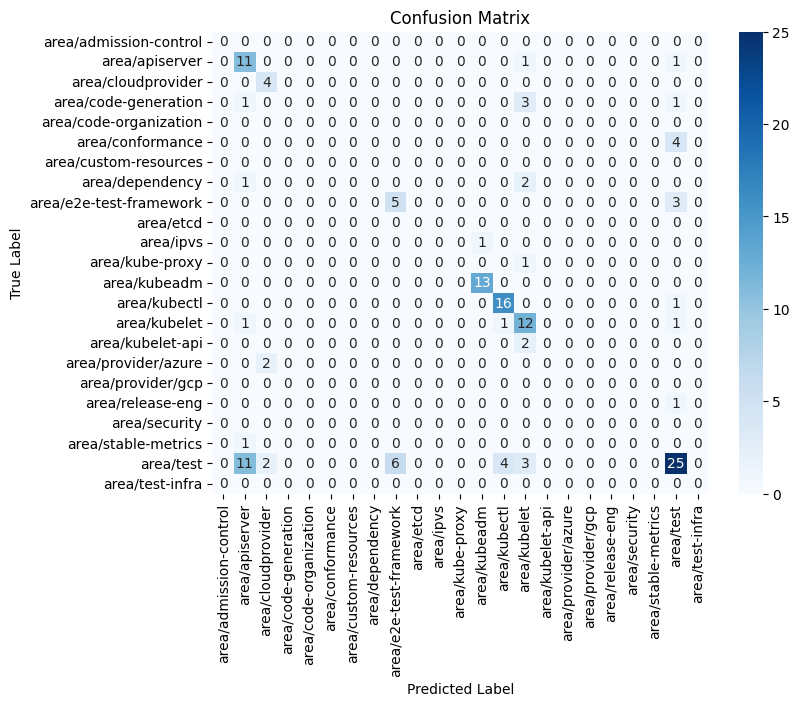

In [25]:
if __name__ == '__main__':
    main()